## 导入包库

In [1]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
# 设置中文字体
matplotlib.font_manager.fontManager.addfont('SimHei.ttf')
matplotlib.rc('font', family='SimHei')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

matplotlib.rc("font",family="SimHei.tff")
plt.rc('font', family='SimHei', size=13)

## 处理数据

In [6]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
# 定义日志根目录
root_log_dirs = ['.\data\lambda0','.\data\lambda0.5','.\data\lambda2','.\data\lambda1000']

# root_log_dirs = ['/home/ubuntu/limeng/projecto_file/highway-new/self_script/highway_rm0127/data/2lane_v3_ori_sp_attention/att_test_gain1/log']

all_data = []  # 存储所有数据的列表

# 外部循环，遍历每个路径
for root_log_dir in root_log_dirs:
    all_rewards = []
    all_lens = []
    all_steps = []

    # 遍历每个子目录（DQN_1, DQN_2, ...）
    for i in range(1, 4):  # 假设有5组数据
        sub_dir = os.path.join(root_log_dir, f'DQN_{i}')
        print(f"Processing {sub_dir}...")

        # 初始化事件累加器并加载事件文件
        event_acc = EventAccumulator(sub_dir, size_guidance={'scalars': 0})
        event_acc.Reload()

        # 检查并提取所需的标量数据
        if 'rollout/ep_rew_mean' in event_acc.Tags()['scalars']:
            episode_rewards = event_acc.Scalars('rollout/ep_rew_mean')
            rewards = [reward.value for reward in episode_rewards]
            all_rewards.append(rewards)
            time_steps = [reward.step for reward in episode_rewards]
            all_steps.append(time_steps)
        else:
            print("Reward data not found.")

        if 'rollout/ep_len_mean' in event_acc.Tags()['scalars']:
            episode_lengths = event_acc.Scalars('rollout/ep_len_mean')
            len_episode = [length.value for length in episode_lengths]
            all_lens.append(len_episode)
        else:
            print("Episode length data not found.")
        
        # plt.plot(time_steps,rewards)
        # plt.show()

    # 确保所有组的数据长度相同，如果不同，需要截断或插值
    min_length = min(len(rewards) for rewards in all_rewards)
    time_steps = time_steps[:min_length]
    
    truncated_rewards = [rewards[:min_length] for rewards in all_rewards]
    truncated_lens = [single_lens[:min_length] for single_lens in all_lens]

    # 计算平均值和标准差
    mean_rewards = np.mean(truncated_rewards, axis=0)
    std_rewards = np.std(truncated_rewards, axis=0)

    mean_lens = np.mean(truncated_lens, axis=0)
    std_lens = np.std(truncated_lens, axis=0)

    # 存储数据到字典
    data_dict = {
        'root_log_dir': root_log_dir,
        'time_steps': time_steps,
        'mean_rewards': mean_rewards,
        'std_rewards': std_rewards,
        'mean_lens': mean_lens,
        'std_lens': std_lens
    }

    # 将字典添加到列表
    all_data.append(data_dict)

# 打印或使用 all_data 列表
print(all_data)

Processing .\data\lambda0\DQN_1...
Processing .\data\lambda0\DQN_2...
Processing .\data\lambda0\DQN_3...
Processing .\data\lambda0.5\DQN_1...
Processing .\data\lambda0.5\DQN_2...
Processing .\data\lambda0.5\DQN_3...
Processing .\data\lambda2\DQN_1...
Processing .\data\lambda2\DQN_2...
Processing .\data\lambda2\DQN_3...
Processing .\data\lambda1000\DQN_1...
Processing .\data\lambda1000\DQN_2...
Processing .\data\lambda1000\DQN_3...
[{'root_log_dir': '.\\data\\lambda0', 'time_steps': [49, 84, 115, 175, 280, 358, 397, 458, 525, 609, 655, 716, 762, 833, 864, 909, 943, 1007, 1093, 1182, 1241, 1300, 1374, 1414, 1465, 1499, 1556, 1633, 1701, 1798, 1874, 1927, 2036, 2160, 2243, 2319, 2383, 2482, 2547, 2632, 2739, 2878, 3022, 3129, 3265, 3424, 3567, 3658, 3804, 3935, 4076, 4217, 4348, 4492, 4652, 4812, 4972, 5090, 5238, 5380, 5535, 5695, 5835, 5973, 6133, 6242, 6402, 6562, 6635, 6792, 6952, 7112, 7272, 7432, 7582, 7707, 7846, 8006, 8157, 8317, 8453, 8602, 8762, 8875, 9035, 9161, 9290, 9383, 951

## 画图

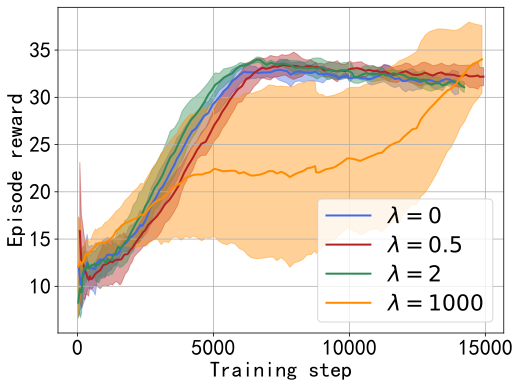

In [7]:
fontsize = 22
model_name = [r'$\lambda=0$','$\lambda=0.5$','$\lambda=2$','$\lambda=1000$']
# Nature 配色方案
colors = ['royalblue', 'firebrick', 'seagreen', 'darkorange', 'purple']

plt.figure(figsize=(8, 6))
# 循环遍历 all_data 列表
for i, data_dict in enumerate(all_data):
    time_steps = data_dict['time_steps']
    mean_rewards = data_dict['mean_rewards']
    std_rewards = data_dict['std_rewards']
    label = f'DQN-{i+1}'  # 添加 DQN 编号
    label = model_name[i]

    # 绘制均值曲线
    plt.plot(time_steps, mean_rewards, color=colors[i], linewidth=2, linestyle='-', label=label)

    # 填充标准差的区域
    plt.fill_between(time_steps, mean_rewards - std_rewards, mean_rewards + std_rewards, color=colors[i], alpha=0.4)

# 设置图例
plt.legend(fontsize=fontsize)
plt.grid()

# 设置坐标轴和刻度大小
plt.tick_params(axis='both', which='both', labelsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# 调整布局
# plt.tight_layout()
# 设置横纵轴标签
# plt.xlabel('时间步', fontsize=18)
# plt.ylabel('回合长度', fontsize=18)
plt.xlabel('Training step',fontsize=fontsize)
plt.ylabel('Episode reward',fontsize=fontsize)
plt.savefig('use_figure/reward.svg')
# 显示图形
plt.show()